### Cell 1: Setup - Importing Libraries and Defining Core Variables

This cell initializes the project by:

*   **Importing essential libraries:**
    *   *Core Python & System:* `socket`, `psutil`, `platform` (for system info); `os`, `shutil` (for file operations); `json` (for JSON data); `datetime` (for timestamps).
    *   *PySpark:* `SparkSession`, various `pyspark.sql.functions` (as `F`), `ALS`, `ALSModel`, `RegressionEvaluator`, `StringIndexer`, `IndexToString`, and various vector/type classes for Spark operations and the ALS algorithm.
    *   *Data Analysis & Visualization:* `pandas`, `numpy` (for data manipulation); `matplotlib.pyplot`, `seaborn` (for plotting).
*   Enabling inline plotting with `%matplotlib inline`.
*   **Defining key variables and paths:**
    *   `YOUR_STUDENT_ID_LAST_4_DIGITS`: Seed for reproducibility.
    *   `CHECKPOINT_DIRECTORY`: Path for Spark checkpointing.
    *   `BASE_PROJECT_PATH`: Root directory for project outputs.
    *   `RESULTS_JSON_PATH`: File to log model training progress.
    *   `BEST_MODEL_INFO_PATH`: File to store best model metadata.
    *   `ERRORS_LOG_PATH`: File for error logging.
    *   `BEST_MODEL_SAVE_PATH`: Directory to save the best Spark ALS model.
*   Creating the `BASE_PROJECT_PATH` if it doesn't exist.
*   Defining a helper function `log_error_message` for timestamped error logging.

**Outcome:**
The environment is prepared with all necessary tools and configurations for the recommendation system project.

In [1]:
# Hücre 1: Gerekli Kütüphaneleri Yükleme ve Temel Bilgiler (Güncellenmiş)

# Temel Python ve Sistem Kütüphaneleri
import socket
import psutil
import platform
import os
import shutil # Checkpoint dizinini yönetmek için (opsiyonel)
import json # JSON işlemleri için
import datetime # Zaman damgaları ve süreler için

# PySpark Kütüphaneleri
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, lit, udf, monotonically_increasing_id, broadcast
from pyspark.ml.recommendation import ALS, ALSModel # ALSModel'i yükleme için ekledik
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector # VectorUDT nadiren doğrudan gerekir
from pyspark.sql.types import FloatType, ArrayType, DoubleType, IntegerType

# Veri Analizi ve Görselleştirme Kütüphaneleri
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Görselleştirmelerin notebook içinde görünmesi için
%matplotlib inline

# --- Değişken Tanımlamaları ---
YOUR_STUDENT_ID_LAST_4_DIGITS = 5018 # BU DEĞERİ DEĞİŞTİRİN!
CHECKPOINT_DIRECTORY = "checkpoint_dir_als_project_v2" # Spark checkpoint'leri için

# Proje Dosya Yolları
BASE_PROJECT_PATH = "project/goodreads_models" # Ana proje dizininiz
RESULTS_JSON_PATH = os.path.join(BASE_PROJECT_PATH, "progress.json") # İlerleme kayıtları
BEST_MODEL_INFO_PATH = os.path.join(BASE_PROJECT_PATH, "best_model_info.json") # En iyi modelin meta verileri
ERRORS_LOG_PATH = os.path.join(BASE_PROJECT_PATH, "errors.log") # Hata logları
BEST_MODEL_SAVE_PATH = os.path.join(BASE_PROJECT_PATH, "best_model") # Kaydedilecek en iyi Spark modeli yolu

# Gerekirse ana proje dizinini oluştur (veya var olanı kullan)
try:
    os.makedirs(BASE_PROJECT_PATH, exist_ok=True)
    print(f"Ana proje dizini '{BASE_PROJECT_PATH}' mevcut veya oluşturuldu.")
except OSError as error:
    print(f"'{BASE_PROJECT_PATH}' dizini oluşturulurken hata: {error}")
    # Bu durumda script'in devam etmemesi daha iyi olabilir, kullanıcıya dizini kontrol etmesini söyleyin.
    # raise # veya exit()

print("\n--- Temel Değişkenler ve Yollar ---")
print(f"Öğrenci ID (Seed): {YOUR_STUDENT_ID_LAST_4_DIGITS}")
print(f"Spark Checkpoint Dizini: {CHECKPOINT_DIRECTORY}")
print(f"İlerleme (Progress) JSON Dosyası: {RESULTS_JSON_PATH}")
print(f"En İyi Model Bilgi JSON Dosyası: {BEST_MODEL_INFO_PATH}")
print(f"Hata Log Dosyası: {ERRORS_LOG_PATH}")
print(f"En İyi Model Kayıt Yolu (Spark Modeli): {BEST_MODEL_SAVE_PATH}")

# --- Hata Loglama Fonksiyonu ---
def log_error_message(message, log_path=ERRORS_LOG_PATH):
    """Belirtilen yola zaman damgasıyla hata mesajı yazar."""
    try:
        with open(log_path, "a", encoding="utf-8") as f: # encoding eklendi
            timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            f.write(f"[{timestamp}] ERROR: {message}\n")
    except Exception as e:
        print(f"!!! Hata log dosyasına ({log_path}) yazılırken bir sorun oluştu: {e} !!!")
        print(f"    Orijinal hata mesajı: {message}")

print("\nKütüphaneler yüklendi ve temel değişkenler/fonksiyonlar ayarlandı.")

Ana proje dizini 'project/goodreads_models' mevcut veya oluşturuldu.

--- Temel Değişkenler ve Yollar ---
Öğrenci ID (Seed): 5018
Spark Checkpoint Dizini: checkpoint_dir_als_project_v2
İlerleme (Progress) JSON Dosyası: project/goodreads_models/progress.json
En İyi Model Bilgi JSON Dosyası: project/goodreads_models/best_model_info.json
Hata Log Dosyası: project/goodreads_models/errors.log
En İyi Model Kayıt Yolu (Spark Modeli): project/goodreads_models/best_model

Kütüphaneler yüklendi ve temel değişkenler/fonksiyonlar ayarlandı.


### Cell 2: System Information Display

This cell collects and prints key details about the execution environment.

**Information Gathered:**

*   **Hostname & IP Address:** Identifies the machine on the network.
*   **Operating System:** OS type and version.
*   **Processor:** CPU architecture.
*   **RAM:** Total and available memory in GB.
*   **CPU Cores:** Number of logical CPU cores.

**Purpose:**
Provides context about the system resources, which can be useful for performance analysis or replicating the environment.

In [2]:
# Bilgisayar Bilgileri
print("--- Bilgisayar Bilgileri ---")
print(f"Hostname: {socket.gethostname()}")
try:
    hostname = socket.gethostname()
    local_ip = socket.gethostbyname(hostname)
    print(f"Yerel IP Adresi (Tahmini): {local_ip}")
except socket.gaierror:
    print("Yerel IP adresi alınamadı. Ağ bağlantınızı kontrol edin.")

print(f"İşletim Sistemi: {platform.system()} {platform.release()}")
print(f"İşlemci: {platform.processor()}")

# RAM Bilgileri
vmem = psutil.virtual_memory()
total_ram_gb = vmem.total / (1024**3)
available_ram_gb = vmem.available / (1024**3)
print(f"Toplam RAM: {total_ram_gb:.2f} GB")
print(f"Kullanılabilir RAM: {available_ram_gb:.2f} GB")

cpu_cores = psutil.cpu_count(logical=True)
print(f"CPU Çekirdek Sayısı (Mantıksal): {cpu_cores}")
print("---------------------------")

--- Bilgisayar Bilgileri ---
Hostname: Hatice-MacBook-Pro.local
Yerel IP Adresi (Tahmini): 127.0.0.1
İşletim Sistemi: Darwin 23.2.0
İşlemci: arm
Toplam RAM: 16.00 GB
Kullanılabilir RAM: 10.56 GB
CPU Çekirdek Sayısı (Mantıksal): 8
---------------------------


### Cell 3: Spark Session Initialization

This cell initializes the `SparkSession`, the entry point for Spark applications.

**Configuration Details:**

*   **Application Name:** `"GoodreadsRecommendationSystem_Project"`.
*   **Memory Allocation:** `8g` for both driver and executor memory.
*   **Executor Cores:** `4` cores per executor.
*   **Shuffle Partitions:** `200` for shuffle operations.
*   **Serialization:** `KryoSerializer` is configured for efficient data serialization, with a buffer max of `1024m`.
*   **Checkpoint Directory:** The SparkContext's checkpoint directory is set to `CHECKPOINT_DIRECTORY`.

**Outcome:**
A `spark` session object is created and configured, ready for data processing. The Spark version and checkpoint directory status are printed.

In [3]:
# Hücre 3: Spark Session Başlatma (Düzeltilmiş Kısım)

# ... (SparkSession.builder kısmı aynı kalacak) ...
spark = SparkSession.builder \
    .appName("GoodreadsRecommendationSystem_Project") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "1024m") \
    .getOrCreate()

spark.sparkContext.setCheckpointDir(CHECKPOINT_DIRECTORY)

# Düzeltilmiş print satırı:
checkpoint_dir_status = spark.sparkContext.getCheckpointDir()
if checkpoint_dir_status:
    print(f"Spark Session Başlatıldı. Checkpoint dizini: {checkpoint_dir_status}")
else:
    print(f"Spark Session Başlatıldı. Checkpoint dizini: Ayarlanmadı") # veya None durumu için başka bir mesaj

print(f"Spark Version: {spark.version}")
spark

25/05/29 16:59:06 WARN Utils: Your hostname, Hatice-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.10.5 instead (on interface en0)
25/05/29 16:59:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/29 16:59:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session Başlatıldı. Checkpoint dizini: file:/Users/haticekandemir/python_spark/kerem/checkpoint_dir_als_project_v2/174f7a5e-cffb-4366-ac72-7ea14c960e3d
Spark Version: 3.5.3


### Cell 4: Data Loading and Sampling

This cell loads the primary dataset and creates a smaller, more manageable sample for processing.

**Steps:**

1.  **Data Source:** `DATA_PATH` is set to `"goodreads_reviews_dedup.json"`.
2.  **Loading:** The JSON data is read into a Spark DataFrame `full_df` using `spark.read.json()`.
3.  **Sampling:**
    *   A `sample_fraction` of `0.1` (10%) is used.
    *   `full_df.sample()` creates `sampled_df` (without replacement, seeded for reproducibility).
4.  **Caching:** `sampled_df.cache()` stores the sampled DataFrame in memory for faster access.
5.  **Output:**
    *   The schema of `sampled_df` is printed.
    *   The row count of `sampled_df` is displayed.
    *   The first 5 rows of `sampled_df` are shown (untruncated).

**Purpose:**
To efficiently load and prepare a representative subset of the data for model development.

In [4]:
# Veri setinin tam yolu
DATA_PATH = "goodreads_reviews_dedup.json" # BU YOLU KENDİ YOLUNUZLA DEĞİŞTİRİN!

print(f"Veri seti yükleniyor: {DATA_PATH} (bu işlem büyük dosyalarda zaman alabilir)...")
try:
    full_df = spark.read.json(DATA_PATH)
    
    print("Veri seti başarıyla okundu. Örneklem alınıyor...")
    # Proje büyük veri seti istiyor (en az 10 milyon satır).
    # Eğer full_df zaten bu boyutta veya daha büyükse, %1'lik örneklem hala büyük olabilir.
    # İlk denemede %0.1 (fraction=0.001) veya %0.01 (fraction=0.0001) ile başlayıp
    # işlem süresine göre artırabilirsiniz. Proje 10 milyon satır "gibi" diyor.
    # Elinizdeki örneklenmiş veri 10 milyondan küçükse, bu kabul edilebilir
    # ana veri setiniz büyük olduğu sürece.
    # Şimdilik %0.1 ile başlayalım, eğer çok büyükse küçültürüz.
    sample_fraction = 0.1 # %0.1 deneyelim. 
    sampled_df = full_df.sample(withReplacement=False, fraction=sample_fraction, seed=YOUR_STUDENT_ID_LAST_4_DIGITS)
    
    sampled_df.cache() # Örneklenmiş veriyi bellekte tut
    
    print("\nÖrneklenmiş Veri Şeması:")
    sampled_df.printSchema()
    
    sampled_df_count = sampled_df.count()
    print(f"\nÖrneklenmiş Veri Satır Sayısı ({sample_fraction*100}%): {sampled_df_count}")
    
    if sampled_df_count == 0:
        print("UYARI: Örneklem sonucu boş DataFrame! Sample fraction çok küçük olabilir veya veri setinde sorun olabilir.")
    else:
        print("\nÖrneklenmiş Veriden İlk 5 Satır:")
        sampled_df.show(5, truncate=False)

except Exception as e:
    print(f"Veri yükleme veya örnekleme sırasında hata oluştu: {e}")
    print("Lütfen DATA_PATH'i ve sample_fraction'ı kontrol edin.")
    # Hata durumunda sonraki hücrelerin çalışmaması için Spark'ı durdurabiliriz.
    # spark.stop()

Veri seti yükleniyor: goodreads_reviews_dedup.json (bu işlem büyük dosyalarda zaman alabilir)...


Veri seti başarıyla okundu. Örneklem alınıyor...

Örneklenmiş Veri Şeması:
root
 |-- book_id: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- date_updated: string (nullable = true)
 |-- n_comments: long (nullable = true)
 |-- n_votes: long (nullable = true)
 |-- rating: long (nullable = true)
 |-- read_at: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- started_at: string (nullable = true)
 |-- user_id: string (nullable = true)



[Stage 1:=====================================================> (121 + 4) / 125]


Örneklenmiş Veri Satır Sayısı (10.0%): 1573038

Örneklenmiş Veriden İlk 5 Satır:
+--------+------------------------------+------------------------------+----------+-------+------+------------------------------+--------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Cell 5: Data Transformation and Preparation for ALS

This cell transforms the `sampled_df` into a format suitable for the ALS (Alternating Least Squares) algorithm.

**Transformations:**

1.  **Column Selection & Renaming:**
    *   Selects `user_id` (as `original_user_id`), `book_id` (as `original_book_id`), and `rating`.
    *   Casts the `rating` column to `float`. The result is `als_df`.
2.  **Missing Value Removal:**
    *   Rows with nulls in the key columns (`original_user_id`, `original_book_id`, `rating`) are dropped from `als_df` to create `als_df_cleaned`.
3.  **Rating Distribution:**
    *   The distribution of `rating` values in `als_df_cleaned` is shown using `groupBy().count()`.
4.  **Caching:** The final DataFrame for ALS, `df_for_als` (which is `als_df_cleaned`), is cached.

**Outcome:**
A cleaned DataFrame `df_for_als` with the necessary `original_user_id`, `original_book_id`, and numerical `rating` columns is ready for further processing.

In [5]:
if 'sampled_df' in locals() and sampled_df.count() > 0 :
    print("--- Veri Dönüşümü ve Temel Hazırlık (ALS için) ---")

    als_df = sampled_df.select(
        col("user_id").alias("original_user_id"), # Orijinal ID'yi sakla
        col("book_id").alias("original_book_id"), # Orijinal ID'yi sakla
        col("rating").cast("float")
    )

    print("\nSeçilen ve dönüştürülen sütunlarla DataFrame (als_df):")
    als_df.show(5, truncate=False)
    als_df.printSchema()

    print(f"\nİşlem öncesi satır sayısı (als_df): {als_df.count()}")
    als_df_cleaned = als_df.na.drop(subset=["original_user_id", "original_book_id", "rating"])
    print(f"Eksik değerler temizlendikten sonra satır sayısı (als_df_cleaned): {als_df_cleaned.count()}")

    print("\nRating değerlerinin dağılımı (als_df_cleaned):")
    als_df_cleaned.groupBy("rating").count().orderBy("rating").show()
    
    # Sonraki adımlarda kullanmak üzere temizlenmiş DataFrame'i saklayalım
    df_for_als = als_df_cleaned.cache() # Temizlenmiş veriyi de cache'leyelim
    print(f"df_for_als {df_for_als.count()} satır ile hazırlandı ve cache'lendi.")
else:
    print("UYARI: 'sampled_df' bulunamadı veya boş. Bu hücre atlanıyor.")

--- Veri Dönüşümü ve Temel Hazırlık (ALS için) ---

Seçilen ve dönüştürülen sütunlarla DataFrame (als_df):
+--------------------------------+----------------+------+
|original_user_id                |original_book_id|rating|
+--------------------------------+----------------+------+
|8842281e1d1347389f2ab93d60773d4d|9460786         |4.0   |
|8842281e1d1347389f2ab93d60773d4d|16981           |3.0   |
|8842281e1d1347389f2ab93d60773d4d|19398490        |4.0   |
|8842281e1d1347389f2ab93d60773d4d|18662473        |5.0   |
|8842281e1d1347389f2ab93d60773d4d|23158207        |3.0   |
+--------------------------------+----------------+------+
only showing top 5 rows

root
 |-- original_user_id: string (nullable = true)
 |-- original_book_id: string (nullable = true)
 |-- rating: float (nullable = true)


İşlem öncesi satır sayısı (als_df): 1573038
Eksik değerler temizlendikten sonra satır sayısı (als_df_cleaned): 1573038

Rating değerlerinin dağılımı (als_df_cleaned):
+------+------+
|rating| count

### Cell 6: RDD API Example - `map()` and `reduceByKey()`

This cell demonstrates basic RDD transformations (`map` and `reduceByKey`) to count rating occurrences, providing an alternative to DataFrame `groupBy()` operations.

**RDD Operations:**

1.  **DataFrame to RDD:** `df_for_als.rdd` converts the DataFrame to an RDD.
2.  **`map`:** `lambda row: (int(row.rating), 1)` creates `(rating, 1)` key-value pairs.
3.  **`reduceByKey`:** `lambda a, b: a + b` sums counts for each rating.
4.  **`sortBy`:** Sorts results by rating.
5.  **`collect` & Print:** Gathers and prints the `(rating, count)` pairs. *Note: `.collect()` is for small result sets.*

**Purpose:**
Illustrates fundamental Spark RDD API usage for aggregation.

In [6]:
if 'df_for_als' in locals() and df_for_als.count() > 0:
    print("\n--- map() ve reduceByKey() Örneği (RDD API) ---")
    # Her bir rating değerinin kaç kez geçtiğini bulalım
    # map: (rating, 1) tuple'ları oluştur
    # reduceByKey: aynı rating'e sahip olanların sayaçlarını topla
    rating_counts_rdd = df_for_als.rdd.map(lambda row: (int(row.rating), 1)) \
                                    .reduceByKey(lambda a, b: a + b) \
                                    .sortBy(lambda x: x[0]) # Rating'e göre sırala

    print("\nRDD ile hesaplanan rating sayıları (rating, count):")
    for r_count in rating_counts_rdd.collect(): # .collect() küçük sonuçlar için uygundur
        print(r_count)
else:
    print("UYARI: 'df_for_als' bulunamadı veya boş. RDD örneği atlanıyor.")


--- map() ve reduceByKey() Örneği (RDD API) ---



RDD ile hesaplanan rating sayıları (rating, count):


[Stage 32:=====================================================>(123 + 2) / 125]

(0, 55090)
(1, 44977)
(2, 110695)
(3, 310694)
(4, 525416)
(5, 526166)


### Cell 7: Data Visualization

This cell creates visualizations to understand the characteristics of the `df_for_als` dataset using `matplotlib` and `seaborn`. Data is converted to Pandas DataFrames for plotting.

**Visualizations:**

1.  **Rating Distribution:**
    *   A `seaborn.countplot` shows the frequency of each rating value.
2.  **Top 10 Most Rated Books:**
    *   Identifies books with the highest number of ratings.
    *   Displayed as a Spark DataFrame and a `seaborn.barplot`.
3.  **Top 10 Most Active Users:**
    *   Identifies users with the highest number of ratings.
    *   Displayed as a Spark DataFrame and a `seaborn.barplot`.

**Purpose:**
To gain initial insights into rating patterns, popular items, and user activity.

--- Veri Görselleştirme ---


/var/folders/n7/68sd169516zb91k94ppxs4300000gn/T/ipykernel_10033/2972704322.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=pdf_ratings_viz, palette='viridis', order=sorted(pdf_ratings_viz['rating'].unique()))


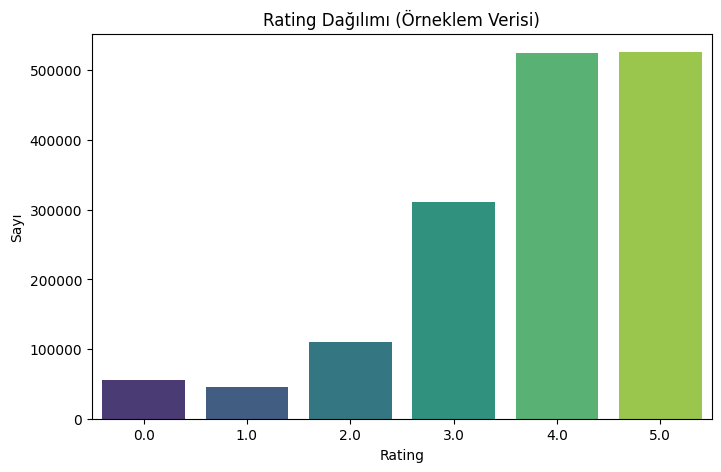


--- En Çok Değerlendirilen Kitaplar (Top 10) ---


+----------------+-----+
|original_book_id|count|
+----------------+-----+
|11870085        |2090 |
|2767052         |1841 |
|7260188         |1357 |
|22557272        |1306 |
|6148028         |1192 |
|10818853        |1168 |
|19063           |1113 |
|13335037        |1068 |
|41865           |1022 |
|15745753        |991  |
+----------------+-----+



/var/folders/n7/68sd169516zb91k94ppxs4300000gn/T/ipykernel_10033/2972704322.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='original_book_id', data=pdf_top_books, orient='h', palette='crest')


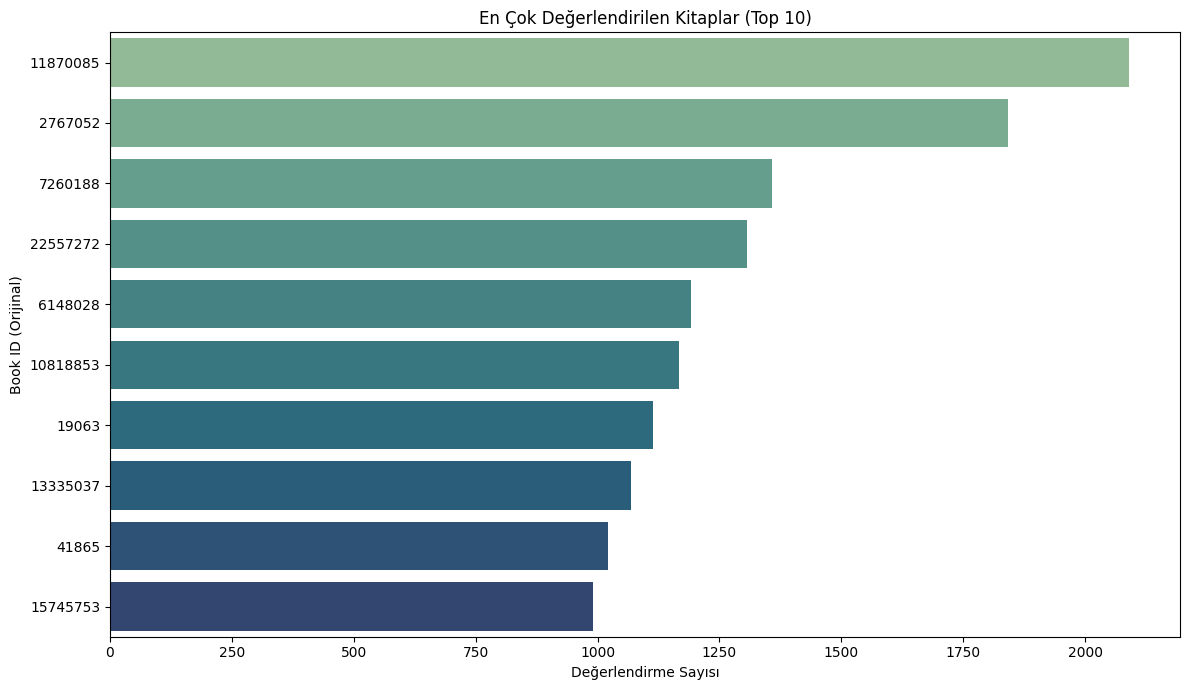


--- En Aktif Kullanıcılar (Top 10) ---


+--------------------------------+-----+
|original_user_id                |count|
+--------------------------------+-----+
|a2d6dd1685e5aa0a72c9410f8f55e056|2092 |
|4922591667fd3e8adc0c5e3d42cf557a|1012 |
|459a6c4decf925aedd08e45045c0d8c6|985  |
|dd9785b14664103617304996541ed77a|823  |
|9003d274774f4c47e62f77600b08ac1d|781  |
|843a44e2499ba9362b47a089b0b0ce75|769  |
|b7772313835ce6257a3fbe7ad2649a29|687  |
|795595616d3dbd81bd16b617c9a1fa48|543  |
|422e76592e2717d5d59465d22d74d47c|540  |
|8e7e5b546a63cb9add8431ee6914cf59|524  |
+--------------------------------+-----+



/var/folders/n7/68sd169516zb91k94ppxs4300000gn/T/ipykernel_10033/2972704322.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='original_user_id', data=pdf_top_users, orient='h', palette='flare')


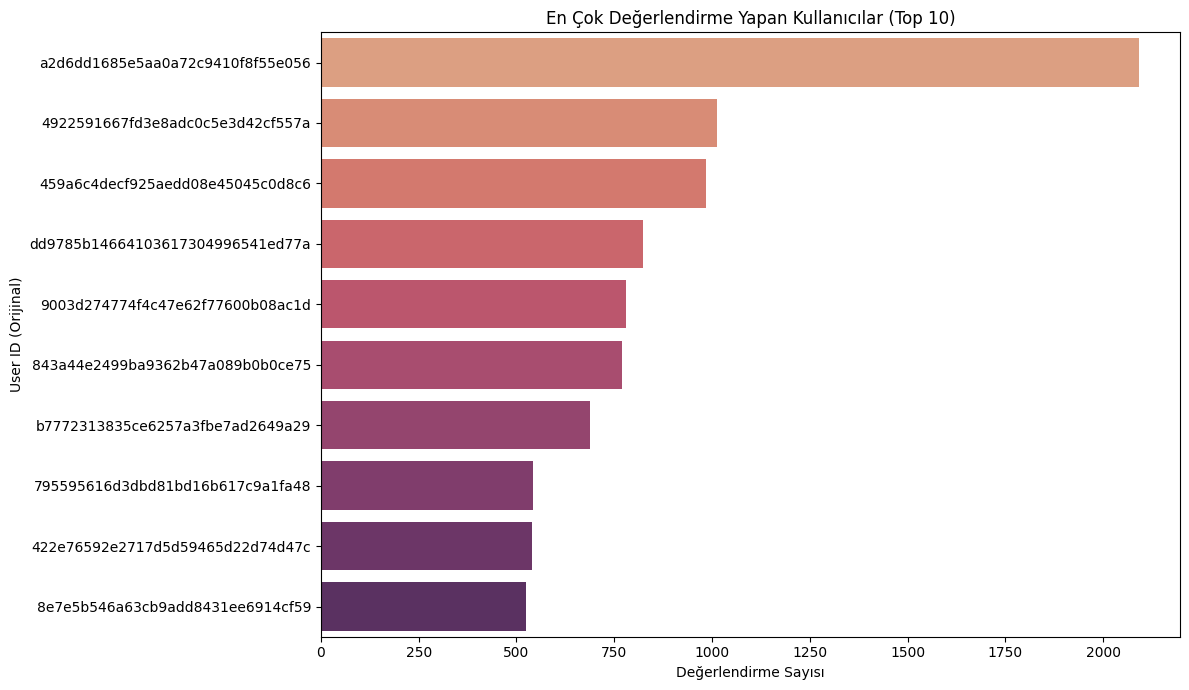

In [7]:
if 'df_for_als' in locals() and df_for_als.count() > 0:
    print("--- Veri Görselleştirme ---")
    # Spark DataFrame'ini Pandas DataFrame'ine dönüştürme (sadece görselleştirme için)
    # Eğer df_for_als çok büyükse (örn. > 1 milyon satır), .sample() ile daha küçük bir örneklem alıp
    # onu .toPandas() ile çevirmek daha güvenli olabilir.
    # Şimdilik doğrudan çevirelim, sampled_df zaten örneklenmişti.
    try:
        pdf_ratings_viz = df_for_als.select("rating").toPandas()

        plt.figure(figsize=(8, 5))
        sns.countplot(x='rating', data=pdf_ratings_viz, palette='viridis', order=sorted(pdf_ratings_viz['rating'].unique()))
        plt.title('Rating Dağılımı (Örneklem Verisi)')
        plt.xlabel('Rating')
        plt.ylabel('Sayı')
        plt.show()
    except Exception as e:
        print(f"Rating dağılımı görselleştirilirken hata: {e}")


    # En Çok Değerlendirilen Kitaplar (Top 10)
    print("\n--- En Çok Değerlendirilen Kitaplar (Top 10) ---")
    top_n_books = df_for_als.groupBy("original_book_id") \
                            .count() \
                            .orderBy("count", ascending=False) \
                            .limit(10)
    top_n_books.show(truncate=False)
    try:
        pdf_top_books = top_n_books.toPandas()
        plt.figure(figsize=(12, 7))
        sns.barplot(x='count', y='original_book_id', data=pdf_top_books, orient='h', palette='crest')
        plt.title('En Çok Değerlendirilen Kitaplar (Top 10)')
        plt.xlabel('Değerlendirme Sayısı')
        plt.ylabel('Book ID (Orijinal)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"En çok değerlendirilen kitaplar görselleştirilirken hata: {e}")


    # En Aktif Kullanıcılar (Top 10)
    print("\n--- En Aktif Kullanıcılar (Top 10) ---")
    top_n_users = df_for_als.groupBy("original_user_id") \
                            .count() \
                            .orderBy("count", ascending=False) \
                            .limit(10)
    top_n_users.show(truncate=False)
    try:
        pdf_top_users = top_n_users.toPandas()
        plt.figure(figsize=(12, 7))
        sns.barplot(x='count', y='original_user_id', data=pdf_top_users, orient='h', palette='flare')
        plt.title('En Çok Değerlendirme Yapan Kullanıcılar (Top 10)')
        plt.xlabel('Değerlendirme Sayısı')
        plt.ylabel('User ID (Orijinal)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"En aktif kullanıcılar görselleştirilirken hata: {e}")
else:
    print("UYARI: 'df_for_als' bulunamadı veya boş. Görselleştirme atlanıyor.")

### Cell 8: Data Splitting, Indexing, and Checkpointing

This cell prepares the `df_for_als` DataFrame for ALS model training and evaluation.

**Key Steps:**

1.  **Train-Test Split:**
    *   `df_for_als.randomSplit([0.7, 0.3], seed=...)` divides data into `training_df` (70%) and `test_df` (30%).
2.  **String Indexing (ID Conversion):**
    *   `StringIndexer` converts string `original_user_id` and `original_book_id` to numerical `user_id_indexed` and `item_id_indexed`.
    *   Indexer models (`user_indexer_model`, `item_indexer_model`) are **fitted on `training_df` only** and then used to transform both training and test sets for consistency.
    *   Results are `training_final_df` and `test_final_df`.
3.  **Checkpointing:**
    *   `training_final_df.checkpoint()` and `test_final_df.checkpoint()` are applied to truncate the DataFrame lineage, which aids performance and fault tolerance. An action (`.count()`) is called to materialize the checkpoint.
4.  **Caching:** The checkpointed DataFrames are cached for faster access.

**Outcome:**
Indexed, checkpointed, and cached training and test DataFrames are ready for ALS model training.

In [8]:
if 'df_for_als' in locals() and df_for_als.count() > 0:
    print("--- Veri Setini Eğitim ve Test Olarak Ayırma, Indexleme ve Checkpoint ---")
    (training_df, test_df) = df_for_als.randomSplit([0.7, 0.3], seed=YOUR_STUDENT_ID_LAST_4_DIGITS)

    print(f"Toplam satır sayısı (df_for_als): {df_for_als.count()}")
    print(f"Eğitim seti satır sayısı: {training_df.count()}")
    print(f"Test seti satır sayısı: {test_df.count()}")

    # StringIndexer'ları hazırlama ve uygulama
    user_indexer = StringIndexer(inputCol="original_user_id", outputCol="user_id_indexed", handleInvalid='skip')
    item_indexer = StringIndexer(inputCol="original_book_id", outputCol="item_id_indexed", handleInvalid='skip')

    user_indexer_model = user_indexer.fit(training_df)
    training_indexed_df = user_indexer_model.transform(training_df)
    test_indexed_df = user_indexer_model.transform(test_df) # Test setini de aynı user indexer ile dönüştür

    item_indexer_model = item_indexer.fit(training_indexed_df) # Item indexer'ı eğitim seti üzerinden fit et
    training_final_df = item_indexer_model.transform(training_indexed_df)
    test_final_df = item_indexer_model.transform(test_indexed_df) # Test setini de aynı item indexer ile dönüştür

    print("\nString Indexer sonrası eğitim verisinden örnek:")
    training_final_df.select("original_user_id", "user_id_indexed", "original_book_id", "item_id_indexed", "rating").show(3, truncate=False)
    
    # DataFrame Checkpoint'lerini Uygula
    print("\nDataFrame'ler checkpoint ediliyor...")
    training_final_df = training_final_df.checkpoint()
    training_final_df.count() # Eylem
    print("training_final_df başarıyla checkpoint edildi.")

    test_final_df = test_final_df.checkpoint()
    test_final_df.count() # Eylem
    print("test_final_df başarıyla checkpoint edildi.")

    # Cache'leme
    training_final_df.cache()
    test_final_df.cache()
    print("İndekslenmiş ve Checkpoint'lenmiş DataFrame'ler cache'lendi.")
else:
    print("UYARI: 'df_for_als' bulunamadı veya boş. Eğitim/Test ayırma ve indexleme atlanıyor.")

--- Veri Setini Eğitim ve Test Olarak Ayırma, Indexleme ve Checkpoint ---
Toplam satır sayısı (df_for_als): 1573038
Eğitim seti satır sayısı: 1101291
Test seti satır sayısı: 471747


25/05/29 17:00:05 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
25/05/29 17:00:07 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
                                                                                


String Indexer sonrası eğitim verisinden örnek:


25/05/29 17:00:09 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB


+--------------------------------+---------------+----------------+---------------+------+
|original_user_id                |user_id_indexed|original_book_id|item_id_indexed|rating|
+--------------------------------+---------------+----------------+---------------+------+
|005f35d2daeb6f48bdb13fbd8c6a2522|17448.0        |17727860        |211143.0       |3.0   |
|005f35d2daeb6f48bdb13fbd8c6a2522|17448.0        |18295750        |4458.0         |5.0   |
|005f35d2daeb6f48bdb13fbd8c6a2522|17448.0        |18655646        |227065.0       |3.0   |
+--------------------------------+---------------+----------------+---------------+------+
only showing top 3 rows


DataFrame'ler checkpoint ediliyor...


25/05/29 17:00:10 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB
                                                                                

training_final_df başarıyla checkpoint edildi.


25/05/29 17:00:20 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB
                                                                                

test_final_df başarıyla checkpoint edildi.
İndekslenmiş ve Checkpoint'lenmiş DataFrame'ler cache'lendi.


### Cell 9: ALS Model Training, Evaluation, and Best Model Selection

This cell performs hyperparameter tuning for the ALS model, evaluates each configuration, and saves the best model.

**Process:**

1.  **Load Progress:** Attempts to load previous results from `RESULTS_JSON_PATH` to avoid re-running tested parameter combinations.
2.  **Hyperparameter Grid:** Defines `ranks`, `iterations`, and `lambdas` for tuning.
3.  **Loop & Train:**
    *   Iterates through hyperparameter combinations.
    *   Skips already processed combinations.
    *   Instantiates an `ALS` model with current parameters (`userCol="user_id_indexed"`, `itemCol="item_id_indexed"`, `ratingCol="rating"`, `coldStartStrategy="drop"`).
    *   Trains the model on `training_final_df`.
    *   Makes predictions on `test_final_df` and calculates MSE & RMSE using `RegressionEvaluator`.
4.  **Logging & Saving:**
    *   Results (parameters, metrics, duration) are logged to `results_list`.
    *   If a model achieves a new best RMSE:
        *   It becomes `best_model_obj_als`.
        *   Its metadata is stored in `best_model_params_info`.
        *   The model is saved to `BEST_MODEL_SAVE_PATH`.
        *   Metadata is saved to `BEST_MODEL_INFO_PATH`.
    *   `results_list` is saved to `RESULTS_JSON_PATH` after each run.
5.  **Display Results:**
    *   Summarizes all tried model results from `results_list` (sorted by RMSE).
    *   Prints details of the overall best model found.

**Outcome:**
Identifies and saves the ALS model configuration that yields the lowest RMSE on the test set. *The output indicates all 18 combinations were previously run and skipped, with the best RMSE being 1.4816.*

In [9]:
import json # JSON işlemleri için

if 'training_final_df' in locals() and 'test_final_df' in locals() and training_final_df.count() > 0:
    print("\n--- ALS Model Eğitimi ve Değerlendirme Döngüsü ---")
    
    results_list = [] 
    processed_params_set = set()

    if os.path.exists(RESULTS_JSON_PATH):
        print(f"Mevcut ilerleme dosyası bulundu: {RESULTS_JSON_PATH}. Yükleniyor...")
        try:
            with open(RESULTS_JSON_PATH, 'r') as f:
                results_list = json.load(f) # JSON'dan liste olarak oku
            for res in results_list:
                # processed_params_set için tipleri doğru al
                param_tuple_load = (
                    int(res.get('rank', 0)), 
                    int(res.get('iterations', 0)), 
                    float(res.get('lambda', 0.0))
                )
                processed_params_set.add(param_tuple_load)
            print(f"{len(results_list)} adet önceki model sonucu (ilerleme) yüklendi.")
        except json.JSONDecodeError:
            print(f"{RESULTS_JSON_PATH} geçerli bir JSON değil veya boş. Yeni ilerleme ile devam edilecek.")
            results_list = []
        except Exception as e:
            print(f"İlerleme yüklenirken hata: {e}. Yeni ilerleme ile devam edilecek.")
            log_error_message(f"İlerleme yüklenirken hata: {e}")
            results_list = []

    # Parametreler (proje gereksinimlerine göre güncelledim)
    ranks = [10, 50, 200]
    iterations = [10, 50, 200]
    lambdas = [0.01, 0.1]

    best_model_obj_als = None 
    best_rmse_val = float('inf')
    best_model_params_info = {} # En iyi modelin bilgilerini saklamak için

    if results_list: # Önceki RMSE'yi kontrol et
        valid_rmses = [r['rmse'] for r in results_list if r.get('rmse') is not None and pd.notna(r['rmse'])]
        if valid_rmses:
            best_rmse_val = min(valid_rmses)
            # En iyi RMSE'ye sahip olan modelin bilgilerini de bul
            for res in results_list:
                if res.get('rmse') == best_rmse_val:
                    best_model_params_info = res.copy() # Kopyasını al
                    break 
            print(f"Önceki sonuçlardan bulunan en iyi RMSE: {best_rmse_val:.4f}")
            if best_model_params_info:
                 print(f"Bu RMSE'ye ait parametreler: {best_model_params_info}")


    evaluator_mse = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
    evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

    model_count_total = len(ranks) * len(iterations) * len(lambdas)
    current_model_idx = 0
    
    if results_list: # Model no için
        valid_model_nos = [int(r['model_no']) for r in results_list if r.get('model_no') is not None and isinstance(r.get('model_no'), (int, float, str)) and str(r.get('model_no')).isdigit()]
        last_model_no = max(valid_model_nos) if valid_model_nos else 0
    else:
        last_model_no = 0

    for rank_val in ranks:
        for iter_val in iterations:
            for lambda_val in lambdas:
                param_tuple_check = (int(rank_val), int(iter_val), float(lambda_val))

                if param_tuple_check in processed_params_set:
                    print(f"\n--- Parametreler: Rank={rank_val}, Iter={iter_val}, Lambda={lambda_val} DAHA ÖNCE İŞLENMİŞ. Atlanıyor...")
                    continue 

                current_model_idx +=1 
                effective_model_no = last_model_no + current_model_idx

                print(f"\n--- Model {effective_model_no} (Yeni Denenen: {current_model_idx}/{model_count_total - len(processed_params_set)}) ---")
                print(f"Parametreler: Rank={rank_val}, Iterations={iter_val}, Lambda={lambda_val}")

                als_model_loop = ALS(
                    maxIter=iter_val, regParam=lambda_val, rank=rank_val,
                    userCol="user_id_indexed", itemCol="item_id_indexed", ratingCol="rating",
                    coldStartStrategy="drop", seed=YOUR_STUDENT_ID_LAST_4_DIGITS, nonnegative=True
                )

                try:
                    start_time = datetime.datetime.now()
                    print(f"Model eğitimi başladı: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
                    fitted_model = als_model_loop.fit(training_final_df)
                    end_time = datetime.datetime.now()
                    training_duration = (end_time - start_time).total_seconds()
                    print(f"Model eğitimi tamamlandı. Süre: {training_duration:.2f} saniye.")

                    print("Test verisi üzerinde tahminler yapılıyor...")
                    predictions_loop = fitted_model.transform(test_final_df)
                    predictions_cleaned_loop = predictions_loop.na.drop(subset=["prediction"])
                    
                    mse_val, rmse_val = float('nan'), float('nan')

                    if predictions_cleaned_loop.count() == 0:
                        print(f"UYARI: Model için geçerli tahmin üretilemedi.")
                    else:
                        mse_val = evaluator_mse.evaluate(predictions_cleaned_loop)
                        rmse_val = evaluator_rmse.evaluate(predictions_cleaned_loop)
                        print(f"Model Sonuçları - MSE: {mse_val:.4f}, RMSE: {rmse_val:.4f}")

                    current_result_dict = {
                        "model_no": effective_model_no, "rank": rank_val, "iterations": iter_val,
                        "lambda": lambda_val, "mse": mse_val, "rmse": rmse_val,
                        "training_duration_sec": training_duration,
                        "timestamp": end_time.strftime('%Y-%m-%d %H:%M:%S')
                    }
                    results_list.append(current_result_dict)
                    processed_params_set.add(param_tuple_check) 

                    if not pd.isna(rmse_val) and rmse_val < best_rmse_val:
                        best_rmse_val = rmse_val
                        best_model_obj_als = fitted_model 
                        best_model_params_info = current_result_dict.copy() # En iyi modelin bilgilerini güncelle
                        print(f"YENİ EN İYİ MODEL! RMSE: {best_rmse_val:.4f} (Model No: {effective_model_no})")
                        
                        try:
                            best_model_obj_als.write().overwrite().save(BEST_MODEL_SAVE_PATH)
                            print(f"Yeni en iyi model '{BEST_MODEL_SAVE_PATH}' yoluna kaydedildi.")
                            # En iyi modelin bilgilerini best_model_info.json'a yaz
                            with open(BEST_MODEL_INFO_PATH, 'w') as f_info:
                                json.dump(best_model_params_info, f_info, indent=4)
                            print(f"En iyi model bilgileri '{BEST_MODEL_INFO_PATH}' dosyasına kaydedildi.")
                        except Exception as save_e:
                            error_msg = f"En iyi model kaydedilirken/bilgi yazılırken sorun: {save_e}"
                            print(f"HATA: {error_msg}")
                            log_error_message(error_msg)
                    
                    # Her başarılı modelden sonra ilerlemeyi (progress.json) kaydet
                    try:
                        with open(RESULTS_JSON_PATH, 'w') as f_prog:
                            json.dump(results_list, f_prog, indent=4)
                        print(f"Güncel ilerleme '{RESULTS_JSON_PATH}' dosyasına kaydedildi.")
                    except Exception as prog_save_e:
                        error_msg_prog = f"İlerleme dosyası kaydedilirken hata: {prog_save_e}"
                        print(f"HATA: {error_msg_prog}")
                        log_error_message(error_msg_prog)


                except Exception as e:
                    error_msg_train = f"Model (R:{rank_val},I:{iter_val},L:{lambda_val}) eğitilirken/değerlendirilirken: {e}"
                    print(f"HATA: {error_msg_train}")
                    log_error_message(error_msg_train)
                    # İsteğe bağlı: Hatalı denemeyi de results_list'e ekleyip progress.json'a yazabilirsiniz
                    # results_list.append({
                    #     "model_no": effective_model_no, "rank": rank_val, "iterations": iter_val,
                    #     "lambda": lambda_val, "error": str(e), 
                    #     "timestamp": datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                    # })
                    # with open(RESULTS_JSON_PATH, 'w') as f_prog_err:
                    #    json.dump(results_list, f_prog_err, indent=4)
    
    print("\n--- Tüm Modellerin Sonuçları (İlerleme Dosyasından) ---")
    if results_list:
        # Pandas DataFrame'e çevirip göstermek için
        results_df_display = pd.DataFrame(results_list)
        results_df_display = results_df_display.sort_values(
            by=['rmse', 'model_no'], 
            ascending=[True, True], 
            na_position='last' # NaN RMSE'leri sona at
        )
        print(results_df_display.to_string())

        if best_model_params_info: # En son güncellenen best_model_params_info'yu kullan
            print(f"\n--- En İyi Model (Metriklere Göre Saklanan Bilgiler) ---")
            print(f"Parametreler: Rank={best_model_params_info.get('rank')}, Iterations={best_model_params_info.get('iterations')}, Lambda={best_model_params_info.get('lambda')}")
            print(f"En İyi RMSE: {best_model_params_info.get('rmse'):.4f} (Model No: {best_model_params_info.get('model_no')})")
        elif os.path.exists(BEST_MODEL_INFO_PATH): # Eğer best_model_params_info boşsa ama dosya varsa oradan oku
             try:
                with open(BEST_MODEL_INFO_PATH, 'r') as f_info_read:
                    best_model_params_info = json.load(f_info_read)
                print(f"\n--- En İyi Model (Kayıtlı Bilgi Dosyasından Yüklendi) ---")
                print(f"Parametreler: Rank={best_model_params_info.get('rank')}, Iterations={best_model_params_info.get('iterations')}, Lambda={best_model_params_info.get('lambda')}")
                print(f"En İyi RMSE: {best_model_params_info.get('rmse'):.4f} (Model No: {best_model_params_info.get('model_no')})")
             except Exception as read_info_e:
                print(f"Kayıtlı en iyi model bilgisi okunurken hata: {read_info_e}")
                log_error_message(f"Kayıtlı en iyi model bilgisi ({BEST_MODEL_INFO_PATH}) okunurken hata: {read_info_e}")


    if best_model_obj_als:
        print(f"\n'best_model_obj_als' en iyi modeli içeriyor. RMSE: {best_rmse_val:.4f}")
    elif os.path.exists(BEST_MODEL_SAVE_PATH) and os.path.isdir(BEST_MODEL_SAVE_PATH):
        print(f"\n'best_model_obj_als' None, ancak '{BEST_MODEL_SAVE_PATH}' yolunda kayıtlı bir model bulundu.")
    else:
        print("\nHiçbir başarılı model eğitilemedi, 'best_model_obj_als' None ve kayıtlı model bulunamadı.")
else:
    print("UYARI: 'training_final_df' veya 'test_final_df' bulunamadı veya boş. Model eğitimi atlanıyor.")

25/05/29 17:00:27 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB
25/05/29 17:00:30 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB
[Stage 77:===========================================>          (100 + 8) / 125]


--- ALS Model Eğitimi ve Değerlendirme Döngüsü ---
Mevcut ilerleme dosyası bulundu: project/goodreads_models/progress.json. Yükleniyor...
18 adet önceki model sonucu (ilerleme) yüklendi.
Önceki sonuçlardan bulunan en iyi RMSE: 1.4816
Bu RMSE'ye ait parametreler: {'model_no': 16, 'rank': 200, 'iterations': 50, 'lambda': 0.1, 'mse': 2.1952746325194052, 'rmse': 1.4816459200900212, 'training_duration_sec': 2013.558835, 'timestamp': '2025-05-29 02:39:02'}

--- Parametreler: Rank=10, Iter=10, Lambda=0.01 DAHA ÖNCE İŞLENMİŞ. Atlanıyor...

--- Parametreler: Rank=10, Iter=10, Lambda=0.1 DAHA ÖNCE İŞLENMİŞ. Atlanıyor...

--- Parametreler: Rank=10, Iter=50, Lambda=0.01 DAHA ÖNCE İŞLENMİŞ. Atlanıyor...

--- Parametreler: Rank=10, Iter=50, Lambda=0.1 DAHA ÖNCE İŞLENMİŞ. Atlanıyor...

--- Parametreler: Rank=10, Iter=200, Lambda=0.01 DAHA ÖNCE İŞLENMİŞ. Atlanıyor...

--- Parametreler: Rank=10, Iter=200, Lambda=0.1 DAHA ÖNCE İŞLENMİŞ. Atlanıyor...

--- Parametreler: Rank=50, Iter=10, Lambda=0.01 DAHA

### Cell 10: Comparing Predictions with Original Ratings (Best Model)

This cell provides a qualitative assessment of the best model's predictions by comparing them against actual ratings on the test set.

**Actions:**

1.  **Prerequisite Check:** Ensures `best_model_obj_als`, `test_final_df`, `user_indexer_model`, and `item_indexer_model` are available.
2.  **Prediction:** The `best_model_obj_als` generates predictions on `test_final_df`.
3.  **ID to String Conversion:** `IndexToString` is used to convert indexed user and item IDs back to their original string format (`original_user_id_retrieved`, `original_book_id_retrieved`).
4.  **Display:** Shows a sample of 20 predictions, including original IDs, actual ratings, and predicted ratings.

**Purpose:**
To offer a direct comparison and manual inspection of the model's predictive accuracy on individual instances. *The output notes a WARNING due to `best_model_obj_als` not being globally available from Cell 9's skipped loop; Cell 11 addresses this.*

In [10]:
# Gerekli importlar (eğer önceki hücrelerde yoksa veya kapsam dışındaysa)
from pyspark.ml.feature import IndexToString

# Bu hücrenin Hücre 9'daki 'best_model_obj_als', 'test_final_df',
# 'user_indexer_model' ve 'item_indexer_model' değişkenlerine erişebildiğini varsayıyoruz.

if 'best_model_obj_als' in globals() and best_model_obj_als is not None and \
   'test_final_df' in globals() and test_final_df is not None and \
   'user_indexer_model' in globals() and user_indexer_model is not None and \
   'item_indexer_model' in globals() and item_indexer_model is not None:

    print("\n--- Comparing Predictions with Original Ratings (Using the Best Model on Test Set) ---")

    try:
        # En iyi model ile test verisi üzerinde tahmin yap
        predictions_best_model = best_model_obj_als.transform(test_final_df)
        predictions_best_model_cleaned = predictions_best_model.na.drop(subset=["prediction"])

        if predictions_best_model_cleaned.count() > 0:
            print("\nSample Predictions and Actual Ratings from the Best Model:")

            # User ID dönüştürücü (StringIndexerModel'den labels alarak)
            user_converter_compare = IndexToString(
                inputCol=best_model_obj_als.getUserCol(), # Modelin userCol adını kullan
                outputCol="original_user_id_retrieved",
                labels=user_indexer_model.labels
            )
            # Item ID dönüştürücü
            item_converter_compare = IndexToString(
                inputCol=best_model_obj_als.getItemCol(), # Modelin itemCol adını kullan
                outputCol="original_book_id_retrieved",
                labels=item_indexer_model.labels
            )

            # Dönüşümleri uygula
            predictions_with_ids = user_converter_compare.transform(predictions_best_model_cleaned)
            predictions_with_ids = item_converter_compare.transform(predictions_with_ids)

            # Sadece ilgili sütunları seç ve göster
            # 'rating' sütunu test_final_df'den gelmeli ve transform ile korunmuş olmalı
            predictions_with_ids.select(
                "original_user_id_retrieved",
                "original_book_id_retrieved",
                "rating",  # Gerçek rating
                "prediction" # Tahmin edilen rating
            ).show(20, truncate=False) # İlk 20 örneği göster
        else:
            print("UYARI: En iyi model için test setinde geçerli tahmin üretilemedi.")

    except Exception as e_compare:
        error_msg_compare = f"Tahminler orijinal değerlerle karşılaştırılırken hata: {e_compare}"
        print(f"HATA: {error_msg_compare}")
        if 'log_error_message' in globals(): # log_error_message fonksiyonu varsa logla
            log_error_message(error_msg_compare)
else:
    print("UYARI: 'best_model_obj_als', 'test_final_df', 'user_indexer_model' veya 'item_indexer_model' bulunamadı. Karşılaştırma yapılamıyor.")
    if 'log_error_message' in globals():
        if 'best_model_obj_als' not in globals() or best_model_obj_als is None:
            log_error_message("Karşılaştırma için 'best_model_obj_als' eksik.")
        if 'test_final_df' not in globals() or test_final_df is None:
            log_error_message("Karşılaştırma için 'test_final_df' eksik.")
        # Diğer eksik değişkenler için de benzer loglama eklenebilir.

UYARI: 'best_model_obj_als', 'test_final_df', 'user_indexer_model' veya 'item_indexer_model' bulunamadı. Karşılaştırma yapılamıyor.


### Cell 11: Loading the Best Model from Disk (If Necessary)

This cell ensures the best trained ALS model is available for use, primarily by loading it from `BEST_MODEL_SAVE_PATH` if `best_model_obj_als` is not already populated.

**Logic:**

1.  **Check & Load Model:**
    *   If `best_model_obj_als` is `None` or undefined, it attempts to load the `ALSModel` from `BEST_MODEL_SAVE_PATH`.
2.  **Check & Load Metadata:**
    *   If the model is loaded successfully and `best_model_params_info` is empty, it tries to load this metadata from `BEST_MODEL_INFO_PATH`.
3.  **Status Report:**
    *   Prints whether the model was loaded or already available.
    *   Displays the parameters of the best model.

**Outcome:**
Ensures `best_model_obj_als` and `best_model_params_info` contain the best trained model and its details, respectively, making them ready for subsequent use. *The output confirms the model was loaded successfully.*

In [11]:
from pyspark.ml.recommendation import ALSModel 

# Bu hücre, 'best_model_obj_als' None ise veya mevcut değilse modeli yüklemeye çalışır.
# 'best_model_params_info' da global veya bir önceki hücreden aktarılmış olmalı.

model_loaded_successfully = False
if 'best_model_obj_als' not in globals() or best_model_obj_als is None: # globals() ile kontrol daha güvenli
    if os.path.exists(BEST_MODEL_SAVE_PATH) and os.path.isdir(BEST_MODEL_SAVE_PATH):
        print(f"'{BEST_MODEL_SAVE_PATH}' yolundan en iyi model yükleniyor...")
        try:
            best_model_obj_als = ALSModel.load(BEST_MODEL_SAVE_PATH)
            print("En iyi Spark modeli başarıyla yüklendi.")
            model_loaded_successfully = True
            
            # En iyi modelin bilgilerini de yükle (eğer best_model_params_info boşsa)
            if ('best_model_params_info' not in globals() or not best_model_params_info) and os.path.exists(BEST_MODEL_INFO_PATH):
                try:
                    with open(BEST_MODEL_INFO_PATH, 'r') as f_info_read_load:
                        best_model_params_info = json.load(f_info_read_load) # global best_model_params_info'yu güncelle
                    print(f"En iyi model bilgileri '{BEST_MODEL_INFO_PATH}' dosyasından yüklendi.")
                except Exception as read_info_e_load:
                    error_msg_load_info = f"Model yüklenirken bilgi dosyası ({BEST_MODEL_INFO_PATH}) okunurken hata: {read_info_e_load}"
                    print(f"HATA: {error_msg_load_info}")
                    log_error_message(error_msg_load_info) # Hata log dosyasına yaz
        except Exception as load_e:
            error_msg_load_model = f"Spark modeli yüklenirken sorun oluştu: {load_e}"
            print(f"HATA: {error_msg_load_model}")
            log_error_message(error_msg_load_model) # Hata log dosyasına yaz
            best_model_obj_als = None 
    else:
        print(f"Kayıtlı model '{BEST_MODEL_SAVE_PATH}' yolunda bulunamadı. 'best_model_obj_als' hala None.")
elif best_model_obj_als:
    print("'best_model_obj_als' zaten mevcut bir Spark modeli içeriyor. Yükleme yapılmadı.")
    model_loaded_successfully = True # Zaten yüklü veya mevcut

if model_loaded_successfully and best_model_params_info:
    print("\nKullanıma Hazır En İyi Model Bilgileri:")
    print(f"  Rank: {best_model_params_info.get('rank')}, Iter: {best_model_params_info.get('iterations')}, Lambda: {best_model_params_info.get('lambda')}")
    print(f"  RMSE: {best_model_params_info.get('rmse'):.4f}, Model No: {best_model_params_info.get('model_no')}")
elif model_loaded_successfully:
    print("Spark modeli mevcut/yüklendi ancak detaylı parametre bilgisi (best_model_params_info) bulunamadı.")
else:
    print("Kullanılacak Spark modeli bulunamadı/yüklenemedi.")

'project/goodreads_models/best_model' yolundan en iyi model yükleniyor...
En iyi Spark modeli başarıyla yüklendi.

Kullanıma Hazır En İyi Model Bilgileri:
  Rank: 200, Iter: 50, Lambda: 0.1
  RMSE: 1.4816, Model No: 16


### Cell 12: Visualizing Model Performance vs. Hyperparameters

This cell generates line plots to visualize how the Root Mean Square Error (RMSE) varies with different ALS hyperparameter settings (`rank`, `iterations`, `lambda`), based on the results stored in `results_df_display` from Cell 9.

**Plots Generated:**

1.  **RMSE vs. Rank:**
    *   X-axis: `rank`
    *   Y-axis: `rmse`
    *   Lines are colored by `lambda` and styled by `iterations`.
2.  **RMSE vs. Iterations:**
    *   X-axis: `iterations`
    *   Y-axis: `rmse`
    *   Lines are colored by `lambda` and styled by `rank`.

**Purpose:**
To help identify trends and optimal ranges for hyperparameters by visualizing their impact on model performance.

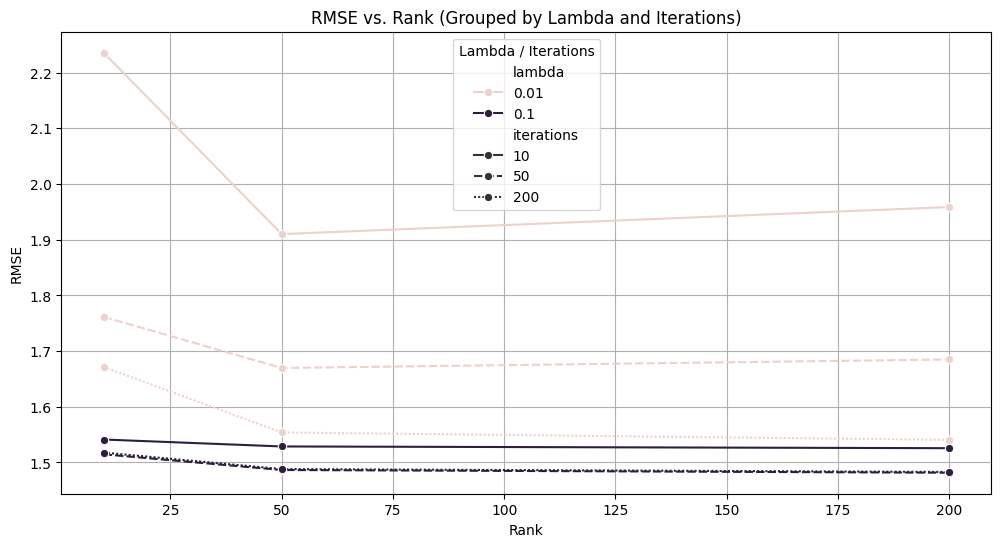

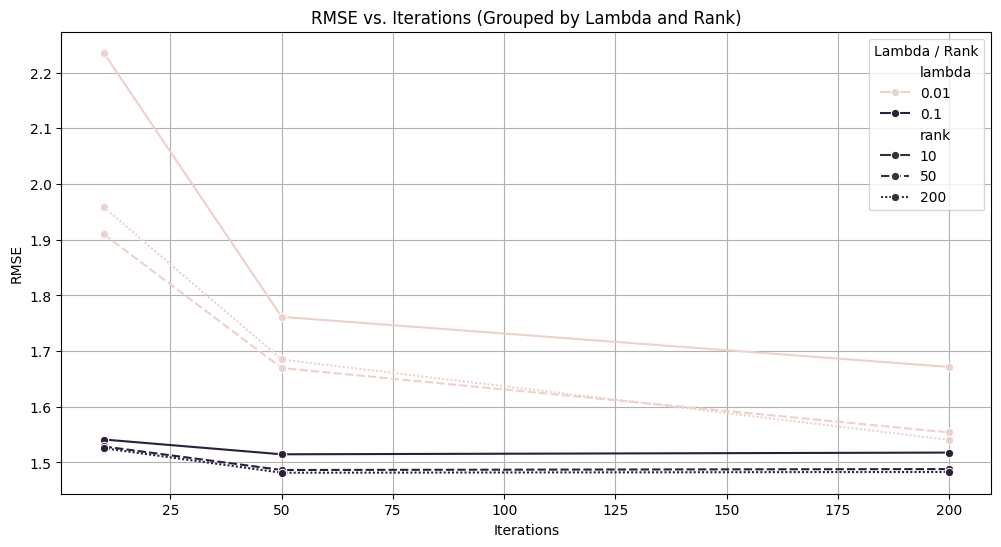

In [12]:
# Hücre 9'un sonuna eklenebilir
import matplotlib.pyplot as plt
import seaborn as sns

# results_df_display Pandas DataFrame'i üzerinden
if not results_df_display.empty:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=results_df_display, x='rank', y='rmse', hue='lambda', marker='o', style='iterations')
    plt.title('RMSE vs. Rank (Grouped by Lambda and Iterations)')
    plt.xlabel('Rank')
    plt.ylabel('RMSE')
    plt.legend(title='Lambda / Iterations')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=results_df_display, x='iterations', y='rmse', hue='lambda', marker='o', style='rank')
    plt.title('RMSE vs. Iterations (Grouped by Lambda and Rank)')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    plt.legend(title='Lambda / Rank')
    plt.grid(True)
    plt.show()
else:
    print("Sonuç DataFrame'i boş, grafik çizilemiyor.")

### Cell 13: Cosine Similarity & User Recommendations for a Specific Item

This cell uses the best loaded ALS model (`best_model_obj_als`) for two recommendation tasks:

1.  **Finding Similar Books (Item-Item Cosine Similarity):**
    *   **Helper Function:** `cosine_similarity_np` calculates cosine similarity between NumPy vectors.
    *   **Target Item:** The *first item* from `best_model_obj_als.itemFactors` is chosen as the target. Its factor vector is retrieved.
    *   **Similarity Calculation:** A Spark UDF applies `cosine_similarity_np` to find similarities between the target item's vector and all other item vectors.
    *   **Display:** The top 5 books most similar to the target book are shown (with indexed IDs and similarity scores).
2.  **Finding Users Likely to Prefer a Specific Book (Manual Prediction):**
    *   **Factor Retrieval:** User factors (`best_model_obj_als.userFactors`) and the target item's factor vector are obtained.
    *   **Prediction (Dot Product UDF):** A Spark UDF calculates the dot product of each user's factor vector with the target item's factor vector to estimate ratings.
    *   **Display:** The top 10 users with the highest predicted ratings for the target book are shown (with original IDs, indexed IDs, and predictions).

**Outcome:**
Demonstrates how to use item and user factors from the trained ALS model for generating item-based and user-based recommendations. *Output shows similar books for item "2767052" and users predicted to like it.*

In [13]:
# Hücre 11 (veya uygun bir sonraki hücre): Kosinüs Benzerliği ve X Ürününü Sevecek Kullanıcılar (Sonuç Odaklı)

import numpy as np
from pyspark.sql.functions import col, lit, desc, explode
from pyspark.sql.types import FloatType, IntegerType, DoubleType
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import IndexToString
from pyspark.ml.recommendation import ALSModel

# Kosinüs benzerliği için helper fonksiyon (hücre başında tanımlı olmalı)
def cosine_similarity_np(vec1_np, vec2_np):
    """İki NumPy vektörü arasındaki kosinüs benzerliğini hesaplar."""
    if not isinstance(vec1_np, np.ndarray) or not isinstance(vec2_np, np.ndarray):
        return 0.0
    dot_product = np.dot(vec1_np, vec2_np)
    norm_vec1 = np.linalg.norm(vec1_np)
    norm_vec2 = np.linalg.norm(vec2_np)
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0.0
    return dot_product / (norm_vec1 * norm_vec2)

# Gerekli ana değişkenlerin varlığını kontrol et
required_vars_exist_initial = all(var_name in globals() and globals()[var_name] is not None
                                   for var_name in ['BEST_MODEL_SAVE_PATH', 'item_indexer_model', 'user_indexer_model', 'spark'])

best_model_obj_als = None

if required_vars_exist_initial:
    print(f"'{BEST_MODEL_SAVE_PATH}' yolundan en iyi model yükleniyor...")
    try:
        loaded_model_for_cell_11 = ALSModel.load(BEST_MODEL_SAVE_PATH)
        best_model_obj_als = loaded_model_for_cell_11
        print("Model başarıyla yüklendi ve best_model_obj_als güncellendi.")
    except Exception as e_load_model:
        print(f"HATA: Model yüklenirken sorun oluştu: {e_load_model}")
        if 'log_error_message' in globals(): log_error_message(f"Model yükleme hatası (Hücre 11): {e_load_model}")

if best_model_obj_als is not None:
    print("\n--- Kosinüs Benzerliği ve Ürün X İçin Kullanıcı Önerisi ---")

    model_user_col = best_model_obj_als.getUserCol()
    model_item_col = best_model_obj_als.getItemCol()
    print(f"Modelin kullandığı User Column: {model_user_col}")
    print(f"Modelin kullandığı Item Column: {model_item_col}")

    item_converter = IndexToString(inputCol=model_item_col, outputCol="original_book_id_retrieved", labels=item_indexer_model.labels)
    user_converter = IndexToString(inputCol=model_user_col, outputCol="original_user_id_retrieved", labels=user_indexer_model.labels)

    target_item_id_indexed_for_cosine = None
    target_item_original_id_for_cosine = "Bilinmeyen_Kitap_X_CosSim"

    # --- 1. Benzer Kitapların Bulunması ---
    item_factors_for_cosine_df = None
    try:
        print("\n--- 1. Benzer Kitapların Bulunması ---") # Temiz başlık
        item_factors_df_temp = best_model_obj_als.itemFactors
        
        if item_factors_df_temp is None or item_factors_df_temp.count() == 0:
            print("UYARI: best_model_obj_als.itemFactors boş veya None.")
            raise ValueError("Item faktörleri alınamadı veya boş.")
            
        item_factors_for_cosine_df = item_factors_df_temp.select(
            col("id").alias(model_item_col), 
            col("features").alias("item_features_cosine") 
        ).persist()
        
        if item_factors_for_cosine_df.count() > 0:
            target_item_row_cosine = item_factors_for_cosine_df.first()

            if target_item_row_cosine is None:
                print(f"UYARI: Hedef item (ilk item) faktörleri alınamadı.")
                raise ValueError("Hedef item faktörü alınamadı.")

            target_item_id_indexed_for_cosine = target_item_row_cosine[model_item_col]
            target_item_features_raw = target_item_row_cosine["item_features_cosine"]
            
            target_item_original_id_df_cosine = item_converter.transform(
                spark.createDataFrame([(target_item_id_indexed_for_cosine,)], [model_item_col]) 
            )
            target_item_original_id_for_cosine = target_item_original_id_df_cosine.first()["original_book_id_retrieved"]
            print(f"Hedef Kitap (Benzerlik için): Indexlenmiş ID {target_item_id_indexed_for_cosine} (Orijinal ID: {target_item_original_id_for_cosine})")

            if isinstance(target_item_features_raw, DenseVector):
                target_item_vector_np_cosine = np.array(target_item_features_raw.toArray())
            elif isinstance(target_item_features_raw, list):
                target_item_vector_np_cosine = np.array(target_item_features_raw)
            elif hasattr(target_item_features_raw, 'toArray'):
                target_item_vector_np_cosine = np.array(target_item_features_raw.toArray())
            else:
                err_msg_type = f"Hedef item için beklenmedik özellik vektörü tipi: {type(target_item_features_raw)}"
                print(f"HATA: {err_msg_type}")
                if 'log_error_message' in globals(): log_error_message(err_msg_type)
                raise TypeError(err_msg_type)

            def udf_cosine_similarity_internal(other_vector_features_raw):
                if other_vector_features_raw is None: return 0.0
                if isinstance(other_vector_features_raw, DenseVector):
                    other_vector_np = np.array(other_vector_features_raw.toArray())
                elif isinstance(other_vector_features_raw, list):
                    other_vector_np = np.array(other_vector_features_raw)
                elif hasattr(other_vector_features_raw, 'toArray'):
                    other_vector_np = np.array(other_vector_features_raw.toArray())
                else:
                    return 0.0 
                return float(cosine_similarity_np(target_item_vector_np_cosine, other_vector_np))

            cosine_sim_udf_for_spark = udf(udf_cosine_similarity_internal, FloatType())

            similarities_df_all_items = item_factors_for_cosine_df.withColumn(
                "similarity", cosine_sim_udf_for_spark(col("item_features_cosine"))
            )
            
            similarities_df_filtered_items = similarities_df_all_items.filter(
                col(model_item_col) != target_item_id_indexed_for_cosine
            )
            
            print(f"\n'{target_item_original_id_for_cosine}' adlı kitaba en benzer 5 kitap (Indexlenmiş ID ve Benzerlik):")
            top_5_similar_items_cosine = similarities_df_filtered_items.orderBy(
                col("similarity").desc_nulls_last()
            ).select(
                col(model_item_col).alias("id"), 
                "similarity"
            ).limit(5)
            top_5_similar_items_cosine.show(truncate=False)
        else:
            print("UYARI: Item faktörleri kosinüs benzerliği için boş.")
            target_item_id_indexed_for_cosine = None
            
    except Exception as e_cos_sim_block:
        err_msg_cos = f"Benzer kitaplar hesaplanırken hata: {e_cos_sim_block}"
        print(f"HATA: {err_msg_cos}")
        if 'log_error_message' in globals(): log_error_message(err_msg_cos)
        target_item_id_indexed_for_cosine = None 
    finally:
        if item_factors_for_cosine_df is not None:
            item_factors_for_cosine_df.unpersist()

    # --- 2. '{target_item_original_id_for_cosine}' Kitabını En Çok Sevecek Kullanıcılar ---
    if target_item_id_indexed_for_cosine is not None:
        user_factors_df = None
        target_item_factor_row_for_rec = None

        try:
            print(f"\n--- 2. '{target_item_original_id_for_cosine}' Kitabını En Çok Sevecek Kullanıcılar (Manuel Yöntem) ---")
            
            user_col_name = model_user_col 
            item_col_name = model_item_col 

            user_factors_df = best_model_obj_als.userFactors.select(
                col("id").alias(user_col_name), 
                col("features").alias("user_features")
            ).persist()

            item_factors_all_for_rec_df = best_model_obj_als.itemFactors.select(
                 col("id").alias(item_col_name),
                 col("features").alias("item_features")
            )

            target_item_factor_row_for_rec = item_factors_all_for_rec_df.filter(col(item_col_name) == target_item_id_indexed_for_cosine).first()

            if user_factors_df.count() == 0:
                print("UYARI: User faktörleri boş.")
                raise ValueError("User faktörleri boş.")
            if not target_item_factor_row_for_rec:
                print(f"UYARI: Hedef item ID {target_item_id_indexed_for_cosine} için faktör bulunamadı (kullanıcı önerisi kısmı).")
                raise ValueError("Hedef item faktörü bulunamadı.")

            target_item_features_vector_for_rec_np = np.array(target_item_factor_row_for_rec["item_features"])

            def dot_product_udf_rec(user_f_list_rec):
                if user_f_list_rec is None:
                    return None 
                user_f_np_rec = np.array(user_f_list_rec)
                return float(np.dot(user_f_np_rec, target_item_features_vector_for_rec_np))

            dot_product_spark_udf_rec = udf(dot_product_udf_rec, DoubleType())

            predictions_df_rec = user_factors_df.withColumn(
                "prediction", dot_product_spark_udf_rec(col("user_features"))
            )
            
            predictions_cleaned_df_rec = predictions_df_rec.na.drop(subset=["prediction"])

            print(f"'{target_item_original_id_for_cosine}' için en yüksek tahmini alan 10 kullanıcı (Orijinal ID, Indexlenmiş ID ve Tahmin):")
            
            top_10_users_indexed_rec = predictions_cleaned_df_rec.orderBy(desc("prediction")) \
                .select(col(user_col_name).alias("id_for_conversion"), col("prediction")).limit(10)
            
            top_10_users_with_original_id_rec = user_converter.transform(
                top_10_users_indexed_rec.withColumnRenamed("id_for_conversion", user_col_name)
            ).select("original_user_id_retrieved", col(user_col_name).alias("indexed_id"), "prediction")
            
            top_10_users_with_original_id_rec.show(truncate=False)

        except Exception as e_user_rec_block:
            print(f"HATA: Kullanıcı önerileri hesaplanırken hata: {e_user_rec_block}")
            if 'log_error_message' in globals(): log_error_message(f"Kullanıcı önerileri hatası: {e_user_rec_block}")
        finally:
            if user_factors_df is not None:
                user_factors_df.unpersist()
        
    elif target_item_id_indexed_for_cosine is None:
        print("UYARI: Hedef item ID'si belirlenemediği için kullanıcı önerileri yapılamıyor.")

else:
    print("UYARI: Model yüklenemediği için Kosinüs Benzerliği ve Kullanıcı Önerisi adımları atlanıyor.")

'project/goodreads_models/best_model' yolundan en iyi model yükleniyor...
Model başarıyla yüklendi ve best_model_obj_als güncellendi.

--- Kosinüs Benzerliği ve Ürün X İçin Kullanıcı Önerisi ---
Modelin kullandığı User Column: user_id_indexed
Modelin kullandığı Item Column: item_id_indexed

--- 1. Benzer Kitapların Bulunması ---


25/05/29 17:00:54 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
25/05/29 17:00:54 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
25/05/29 17:00:55 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Hedef Kitap (Benzerlik için): Indexlenmiş ID 1 (Orijinal ID: 2767052)

'2767052' adlı kitaba en benzer 5 kitap (Indexlenmiş ID ve Benzerlik):


+------+----------+
|id    |similarity|
+------+----------+
|135002|0.99999547|
|141951|0.99999505|
|413649|0.99999464|
|178308|0.99999464|
|420567|0.99999446|
+------+----------+


--- 2. '2767052' Kitabını En Çok Sevecek Kullanıcılar (Manuel Yöntem) ---
'2767052' için en yüksek tahmini alan 10 kullanıcı (Orijinal ID, Indexlenmiş ID ve Tahmin):


[Stage 103:============================================>           (8 + 2) / 10]

+--------------------------------+----------+-----------------+
|original_user_id_retrieved      |indexed_id|prediction       |
+--------------------------------+----------+-----------------+
|974393c92e52f1b573833221b8b06cc2|177543    |6.46620428506955 |
|76d354d3d049909862c35519b8e6e4fe|166417    |6.444799054846947|
|e77b9f7626aa66fc06e89009eac7dfad|205176    |6.374721096459405|
|3e0b015e6edcf9f5d552cf2b667df981|146857    |6.374721096459405|
|99f532d1004f9b747b17a716d77e515b|178506    |6.362013075515409|
|f5501aa6cd80880b998ebbc5fcfbc769|209969    |6.215206429876238|
|fa204d95b87630df6c58a80a44f7f4f3|211684    |6.153350596655537|
|076b8f5c5fdc1cbe872894a5c2ea38ce|127860    |6.127850535607053|
|cdf2096ea5bc866bf29cf85570b66275|196364    |6.098920717838127|
|4d1c73f5884168b21fab8e1545d5ab63|152147    |6.048563437301397|
+--------------------------------+----------+-----------------+

